In [1]:
!pip install -q kaggle

In [2]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from torchsummary import summary
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from PIL import Image
from torch import optim
import cv2, glob, numpy as np, pandas as pd
from glob import glob
from torch.utils.data import DataLoader, Dataset
from google.colab import files

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [4]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip

Streaming output truncated to the last 5000 lines.
  inflating: training_set/training_set/cats/cat.3704.jpg  
  inflating: training_set/training_set/cats/cat.3705.jpg  
  inflating: training_set/training_set/cats/cat.3706.jpg  
  inflating: training_set/training_set/cats/cat.3707.jpg  
  inflating: training_set/training_set/cats/cat.3708.jpg  
  inflating: training_set/training_set/cats/cat.3709.jpg  
  inflating: training_set/training_set/cats/cat.371.jpg  
  inflating: training_set/training_set/cats/cat.3710.jpg  
  inflating: training_set/training_set/cats/cat.3711.jpg  
  inflating: training_set/training_set/cats/cat.3712.jpg  
  inflating: training_set/training_set/cats/cat.3713.jpg  
  inflating: training_set/training_set/cats/cat.3714.jpg  
  inflating: training_set/training_set/cats/cat.3715.jpg  
  inflating: training_set/training_set/cats/cat.3716.jpg  
  inflating: training_set/training_set/cats/cat.3717.jpg  
  inflating: training_set/training_set/cats/cat.3718.jpg  
  infl

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [6]:
trainingset_dir = '/content/training_set/training_set'
testset_dir = '/content/test_set/test_set'

In [7]:
class CatsDogs(Dataset):
  def __init__(self,folder):
    cats = glob(pathname=f'{folder}/cats/*.jpg')
    dogs = glob(pathname=f'{folder}/dogs/*.jpg')
    self.fpaths = cats[:500] + dogs[:500]
    self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    from random import shuffle, seed; seed(10);

    shuffle(self.fpaths)
    self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
  def __len__(self):
    return len(self.fpaths)
  def __getitem__(self,ix):
    f = self.fpaths[ix]
    target = self.targets[ix]
    im = (cv2.imread(f)[:,:,::-1])
    im = cv2.resize(im,[224,224])
    im =  torch.tensor(im/255)
    im = im.permute(2,0,1)
    im = self.normalize(im)
    return (
        im.float().to(device),
        torch.tensor([target]).float().to(device)
    )



tensor([0.], device='cuda:0')


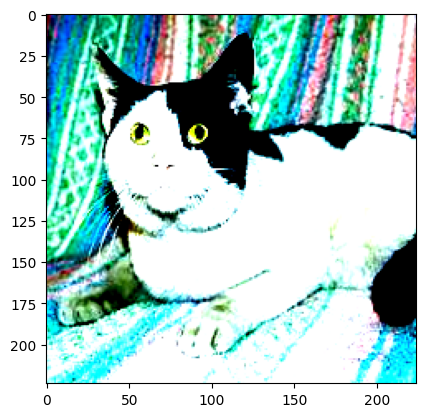

In [8]:
data = CatsDogs(trainingset_dir)
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)
plt.show()

In [19]:
def get_model():
  model = models.resnet18(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False
  model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
  model.fc = nn.Sequential(
      nn.Flatten(),
      nn.Linear(512,128),
      nn.ReLU(),
      nn.Dropout(0.2),
      nn.Linear(128,1),
      nn.Sigmoid(),
  )
  loss_fn = nn.BCELoss()
  optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
  return model.to(device), loss_fn, optimizer




In [20]:
model , criterion, optimizer = get_model()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
summary(model,(3,224,224),batch_size=1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [1, 64, 112, 112]           9,408
       BatchNorm2d-2          [1, 64, 112, 112]             128
              ReLU-3          [1, 64, 112, 112]               0
         MaxPool2d-4            [1, 64, 56, 56]               0
            Conv2d-5            [1, 64, 56, 56]          36,864
       BatchNorm2d-6            [1, 64, 56, 56]             128
              ReLU-7            [1, 64, 56, 56]               0
            Conv2d-8            [1, 64, 56, 56]          36,864
       BatchNorm2d-9            [1, 64, 56, 56]             128
             ReLU-10            [1, 64, 56, 56]               0
       BasicBlock-11            [1, 64, 56, 56]               0
           Conv2d-12            [1, 64, 56, 56]          36,864
      BatchNorm2d-13            [1, 64, 56, 56]             128
             ReLU-14            [1, 64,

In [22]:
def train_batch(x,y,model,optimizer,loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction,y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()


In [23]:
@torch.no_grad()
def accuracy(x,y,model):
  model.eval()
  prediction = model(x)
  is_correct = ((prediction > 0.5).float() == y).float()
  return is_correct.cpu().numpy().tolist()

In [24]:
def get_data():
  trainset = CatsDogs(trainingset_dir)
  trainloader = DataLoader(trainset,batch_size=32,shuffle=True,drop_last=True)
  val = CatsDogs(testset_dir)
  valloader = DataLoader(val,batch_size=32,shuffle=True,drop_last=False)
  return trainloader, valloader

In [25]:
trainloader, valloader = get_data()
model,loss_fn, optimizer= get_model()

In [32]:
train_losses, train_accuracies = [], []
val_accuracy = []
for epoch in range(10):
  print(f'epoch {epoch + 1}/5')
  train_epoch_losses,train_epoch_accuracies = [],[]
  val_epoch_accuracies = []

  for ix ,batch in enumerate(iter(trainloader)):
    x,y = batch
    batch_loss = train_batch(x,y,model,optimizer,loss_fn)
    train_epoch_losses.append(batch_loss)

  train_epoch_loss = np.mean(train_epoch_losses).mean()

  for ix, batch in enumerate(iter(trainloader)):
    x,y = batch
    is_correct = accuracy(x,y,model)
    train_epoch_accuracies.append(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)

  for ix, batch in enumerate(iter(valloader)):
    x,y = batch
    val_is_correct = accuracy(x,y,model)
    val_epoch_accuracies.extend(val_is_correct)
  val_epoch_accuracy = np.mean(val_epoch_accuracies)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_accuracy.append(val_epoch_accuracy)

  print(f"Training Loss: {train_epoch_loss} - Training accuracy: {train_epoch_accuracy} - Validation Accuracy: {val_epoch_accuracy}")

epoch 1/5
Training Loss: 0.07408085627661597 - Training accuracy: 0.9747983870967742 - Validation Accuracy: 0.963
epoch 2/5
Training Loss: 0.09604788989189171 - Training accuracy: 0.9899193548387096 - Validation Accuracy: 0.977
epoch 3/5
Training Loss: 0.0501835135923278 - Training accuracy: 0.9899193548387096 - Validation Accuracy: 0.98
epoch 4/5
Training Loss: 0.06219569428433334 - Training accuracy: 0.9798387096774194 - Validation Accuracy: 0.967
epoch 5/5
Training Loss: 0.09748516054523568 - Training accuracy: 0.9889112903225806 - Validation Accuracy: 0.97
epoch 6/5
Training Loss: 0.07661986936845126 - Training accuracy: 0.9929435483870968 - Validation Accuracy: 0.975
epoch 7/5
Training Loss: 0.04854877392250684 - Training accuracy: 0.9949596774193549 - Validation Accuracy: 0.977
epoch 8/5
Training Loss: 0.049474669470181386 - Training accuracy: 0.9959677419354839 - Validation Accuracy: 0.978
epoch 9/5
Training Loss: 0.05703816319545431 - Training accuracy: 0.9969758064516129 - Val

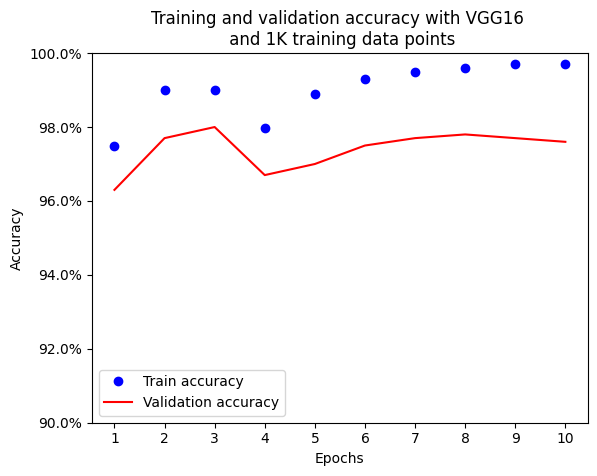

In [36]:
epochs = np.arange(10)+1
plt.plot(epochs, train_accuracies,'bo',label="Train accuracy")
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \n and 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.90,1)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.legend()
plt.grid(False)
plt.show()